# Density-Based Clustering (DBSCAN)
    Discovering Natural Clusters and Anomalies Without K

## Objective

This notebook provides a systematic and practical treatment of density-based clustering, covering:

- Why density-based methods exist

- DBSCAN intuition and parameters

- Cluster discovery without specifying K

- Noise and anomaly detection

- Strengths and limitations in financial data

It answers:

How can we discover clusters of arbitrary shape and detect anomalies simultaneously?

## Business Context – Why DBSCAN in Finance?

DBSCAN is especially valuable when:

- Data contains outliers or fraud

- Cluster shapes are non-spherical

- Noise is meaningful (not an error)

- The number of clusters is unknown

Typical finance use cases:

- Fraud and anomaly detection

- Transaction pattern discovery

- Customer behavior irregularities

- Risk outlier identification

## Imports and Dataset

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("D:/GitHub/Data-Science-Techniques/datasets/Unsupervised/synthetic_bank_customer_segmentation.csv")

df.head()

,age,annual_income,avg_monthly_spend,credit_utilization,tenure_years,num_products,risk_score
0,56,106477.0,5268.0,0.06,3.1,1,24.1
1,69,109688.0,2206.0,0.00,2.0,1,22.0
2,46,94629.0,2998.0,0.22,3.2,1,36.1
3,32,49359.0,1725.0,0.17,4.6,1,24.4
4,60,91565.0,1807.0,0.06,21.3,7,17.3


### Dataset Features


| Feature            | Description           |
| ------------------ | --------------------- |
| age                | Customer age          |
| annual_income      | Annual income         |
| avg_monthly_spend  | Monthly spending      |
| credit_utilization | Credit usage ratio    |
| tenure_years       | Relationship duration |
| num_products       | Products owned        |
| risk_score         | Internal risk metric  |


### Feature Selection

DBSCAN is distance-based and requires numerical features.

#### Feature Matrix

In [2]:
features = [
    "age",
    "annual_income",
    "avg_monthly_spend",
    "credit_utilization",
    "tenure_years",
    "num_products",
    "risk_score"
]

X = df[features]


### Scaling (Non-Negotiable)

DBSCAN is extremely sensitive to scale.

#### Standardization

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# DBSCAN Intuition

DBSCAN groups points based on local density:

- **Core points:** dense regions

- **Border points:** near dense regions

- **Noise points:** isolated (label = -1)

Key parameters:

- `eps:` neighborhood radius

- `min_samples:` minimum points to form a dense region

## – Choosing eps (k-Distance Plot)

A common heuristic uses the **k-distance curve.**

### k-Distance Plot

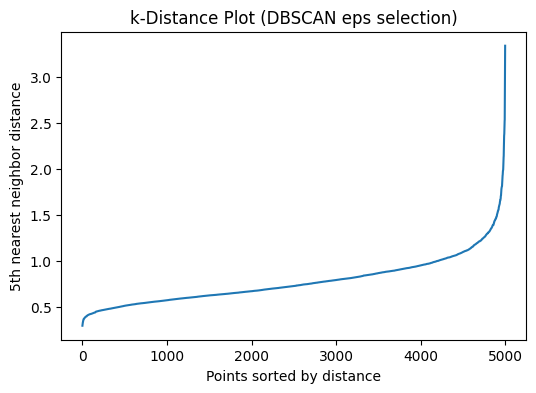

In [4]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, _ = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, 4])

plt.figure(figsize=(6, 4))
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("5th nearest neighbor distance")
plt.title("k-Distance Plot (DBSCAN eps selection)")
plt.show()


✔ Look for the elbow point

✔ Finance data often needs conservative eps

###  Fit DBSCAN
### DBSCAN Model

In [5]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(
    eps=0.8,
    min_samples=5
)

df["cluster"] = dbscan.fit_predict(X_scaled)


### Cluster Labels Interpretation

In [6]:
df["cluster"].value_counts()


cluster
 0     3591
-1     1273
 1       43
 5       18
 4       10
 8        8
 9        7
 7        6
 10       5
 3        5
 16       5
 13       5
 11       5
 14       5
 15       4
 2        4
 6        4
 12       2
Name: count, dtype: int64

- -1 → Noise / anomalies

- 0, 1, 2... → Dense clusters

✔ Noise is signal, not error

## Noise Analysis (Critical)
### Noise Proportion

In [7]:
noise_ratio = (df["cluster"] == -1).mean()
noise_ratio


np.float64(0.2546)

High noise may indicate:

- True anomalies

- Poor eps choice

- High-dimensional sparsity

## Cluster Profiling (Excluding Noise)
### Profile Clusters

In [8]:
cluster_profile = (
    df[df["cluster"] != -1]
    .groupby("cluster")[features]
    .mean()
    .round(2)
)

cluster_profile


,age,annual_income,avg_monthly_spend,credit_utilization,tenure_years,num_products,risk_score
cluster,,,,,,,
0,45.00,83581.08,2765.34,0.17,2.95,1.48,28.65
1,64.86,111338.21,4823.16,0.05,6.19,3.02,20.55
2,58.75,92562.00,2340.75,0.37,6.15,3.00,36.78
3,68.20,115321.20,4553.40,0.14,9.20,2.00,24.94
4,58.60,101370.20,4355.00,0.04,5.60,4.00,15.68
5,45.33,80019.56,2524.89,0.05,5.30,4.00,19.22
6,48.00,91071.50,3665.00,0.42,1.62,2.00,44.22
7,62.67,111700.83,3354.50,0.00,14.52,3.00,14.08
8,36.25,78423.75,2084.75,0.15,5.51,4.00,28.12


## Example Business Interpretation

| Cluster | Interpretation                  |
| ------- | ------------------------------- |
| 0       | Stable, low-risk customers      |
| 1       | High-spend, high-income segment |
| -1      | Irregular / risky behavior      |


✔ DBSCAN naturally separates **normal vs abnormal**

## Visualization via PCA
### PCA Projection

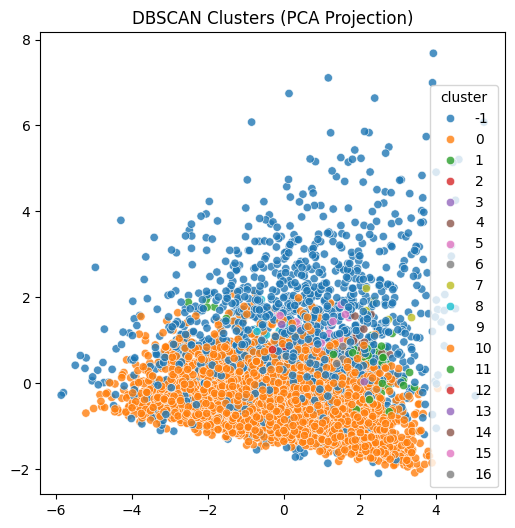

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df["cluster"],
    palette="tab10",
    alpha=0.8
)
plt.title("DBSCAN Clusters (PCA Projection)")
plt.show()


## DBSCAN vs K-Means vs Hierarchical


| Aspect           | DBSCAN | K-Means | Hierarchical |
| ---------------- | ------ | ------- | ------------ |
| Requires K       | ❌      | ✔       | ❌            |
| Handles noise    | ✔      | ❌       | ❌            |
| Arbitrary shapes | ✔      | ❌       | ❌            |
| Interpretability | Medium | Medium  | High         |
| Scalability      | Medium | High    | Low          |


## Limitations of DBSCAN

- - `[con] -` Sensitive to eps
- - `[con] -` Struggles in high dimensions
- - `[con] -` Poor with varying density
- - `[con] -` No probabilistic output

## Common Mistakes (Avoided)

- - `[con] -` Skipping scaling
- - `[con] -` Treating noise as error
- - `[con] -` Using DBSCAN blindly for segmentation
- - `[con] -` Expecting stable cluster counts
- - `[con] -` Using categorical features

## When DBSCAN Is the Right Choice

- ✔ Fraud detection
- ✔ Anomaly discovery
- ✔ Irregular behavior detection
- ✔ Unknown cluster structure
- ✔ Noise is meaningful

## Key Takeaways

- DBSCAN discovers structure and anomalies

- Noise points are valuable signals

- eps selection is critical

- Scaling is mandatory

- Ideal for fraud and risk analytics

## Next Notebook
05_Unsupervised_Learning/


└── 01_clustering/
    
  - └── [04_clustering_validation_and_stability](04_clustering_validation_and_stability.ipynb)

<br><br><br><br><br>



# Complete: [Data Science Techniques](https://github.com/lei-soares/Data-Science-Techniques)

- [00_Data_Generation_and_Simulation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/00_Data_Generation_and_Simulation)


- [01_Exploratory_Data_Analysis_(EDA)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/01_Exploratory_Data_Analysis_(EDA))


- [02_Data_Preprocessing](https://github.com/lei-soares/Data-Science-Techniques/tree/main/02_Data_Preprocessing)


- [03_Feature_Engineering](https://github.com/lei-soares/Data-Science-Techniques/tree/main/03_Feature_Engineering)


- [04_Supervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/04_Supervised_Learning)

    - [Regression Models](https://github.com/lei-soares/Data-Science-Techniques/tree/49de369e0600a513b54445e8cb4196b26ce71853/04_Supervised_Learning/01_regression_models)
    
    - [Classification Models](https://github.com/lei-soares/Data-Science-Techniques/tree/49de369e0600a513b54445e8cb4196b26ce71853/04_Supervised_Learning/02_classification_models)


- [05_Unsupervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/05_Unsupervised_Learning)


- [06_Model_Evaluation_and_Validation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/06_Model_Evaluation_and_Validation)


- [07_Model_Tuning_and_Optimization](https://github.com/lei-soares/Data-Science-Techniques/tree/main/07_Model_Tuning_and_Optimization)


- [08_Interpretability_and_Explainability](https://github.com/lei-soares/Data-Science-Techniques/tree/main/08_Interpretability_and_Explainability)


- [09_Pipelines_and_Workflows](https://github.com/lei-soares/Data-Science-Techniques/tree/main/09_Pipelines_and_Workflows)


- [10_Natural_Language_Processing_(NLP)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/10_Natural_Language_Processing_(NLP))


- [11_Time_Series](https://github.com/lei-soares/Data-Science-Techniques/tree/main/11_Time_Series)


- [12_Anomaly_and_Fraud_Detection](https://github.com/lei-soares/Data-Science-Techniques/tree/main/12_Anomaly_and_Fraud_Detection)


- [13_Imbalanced_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/13_Imbalanced_Learning)


- [14_Deployment_and_Production_Concepts](https://github.com/lei-soares/Data-Science-Techniques/tree/main/14_Deployment_and_Production_Concepts)


- [15_Business_and_Experimental_Design](https://github.com/lei-soares/Data-Science-Techniques/tree/main/15_Business_and_Experimental_Design)




<br><br><br><br><br>

[Panfugo Dados](www.pantufodados.com)


[Pantufo Dados - YouTube Channel](https://www.youtube.com/@pantufodados)